In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

In [2]:
def Gaussian(i, mean, sigma):
  '''
    mean    : duration at which number of registered vehicles are maximum
    sigma   : rate of increase in sales 

    return  : ((1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(i-mean)**2/(2*sigma**2)))
  '''
  return ((1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(i-mean)**2/(2*sigma**2)))

def stretched_exp_func(x, x_shift,A, tau, beta):
  '''
    x_shift : duration at which number of registered vehicles are maximum
    A       : maximum number of vehicles
    tau     : characteristic time scale that determines how slowly the number of registered vehicles decays
    β       : shape parameter that determines the shape of the decay curve (higher the beta, quicker the drop from highest to lowest value)

    return  : A * np.exp(-((x-x_shift)/ tau) ** beta)
  '''
  return A * np.exp(-((x-x_shift)/ tau) ** beta)

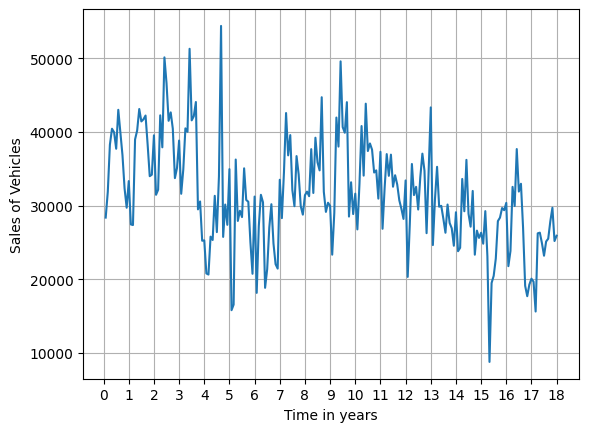

In [5]:
data = pd.read_csv("monthlysales.csv", names = ["Sales"])
years = 18
sales = [int(i.replace(',','')) for i in data['Sales']]
len(sales)
sum_sales = [sum(sales[0:i+1]) for i in range(len(sales))]
plt.plot(np.linspace(1,len(sales),len(sales)), sales)
plt.xlabel('Time in years')
plt.ylabel('Sales of Vehicles')
plt.xticks([i*12 for i in range(years +1)], [i for i in range(years +1)])
plt.grid()
plt.show()

from google.colab import drive
drive.mount('/content/drive')

Enter expected duration of manufacturing the vehicle (In years): 5
Enter expected sales in that duration: 1000
75198


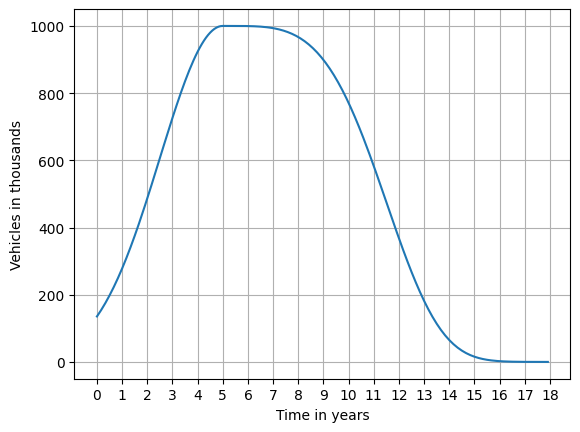

In [6]:
manufacturing_years = int(input("Enter expected duration of manufacturing the vehicle (In years): "))
# 6
total_sales = int(input("Enter expected sales in that duration: "))
# 1500 in thousands

t_months = manufacturing_years*12
# p_maxima = (t_months**t_months)*np.exp(-t_months)/np.math.factorial(t_months)

# m_factor = total_sales/p_maxima
years = 18
duration = years*12

time = np.fromfunction(lambda i: i, shape=(duration,), dtype=int)
# vehicles2 = []
l = manufacturing_years*12
# for i in range(duration):
  # vehicles2.append((l**i)*np.exp(-l)/np.math.factorial(i))

mean = manufacturing_years*12
sigma = mean/2

A = total_sales
tau = 84
beta = 4

vehicles = np.zeros(duration)

for i in range(l):
  vehicles[i] = Gaussian(i, mean, sigma)
scale = int(total_sales*(sigma*np.sqrt(2*np.pi)))
vehicles = vehicles*scale

for i in range(l,duration):
  vehicles[i] = stretched_exp_func(i,l,A, tau, beta)


print(scale)


plt.plot(time, vehicles)
plt.xlabel('Time in years')
plt.ylabel('Vehicles in thousands')
plt.xticks([i*12 for i in range(years +1)], [i for i in range(years +1)])
plt.grid()
plt.show()

# print(p_maxima)

In [16]:
# batteries
# range 0 to 1
climate_factor = [0.2, 0.2, 0.25, 0.28, 0.28, 0.35, 0.45, 0.5, 0.4, 0.35, 0.3, 0.22]

# range -1 to 1
economic_factor = np.random.uniform(low=-0.3, high=0.5, size=(duration//12,))
# economic_factor = np.random.rand(duration//12)

# range -1 to 1
brand_factor = np.random.uniform(low=-0.5, high=0.5, size=(duration//12,))
# brand_factor = np.random.rand(duration)


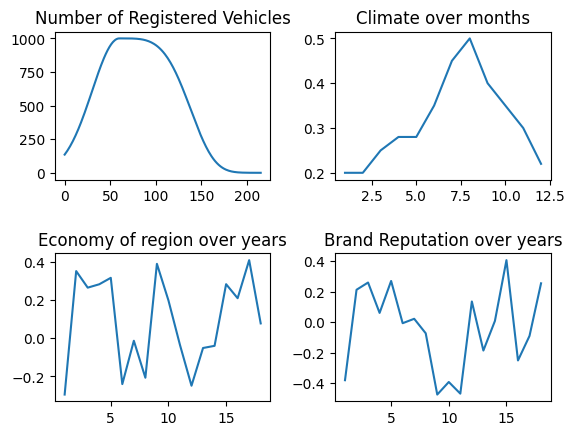

In [18]:
plt.subplot(2, 2, 1)
plt.plot(time, vehicles)
plt.title('Number of Registered Vehicles')

plt.subplot(2, 2, 2)
plt.plot(np.linspace(1, 12, 12), climate_factor)
plt.title('Climate over months')

plt.subplot(2, 2, 3)
plt.plot(np.linspace(1, duration//12, duration//12), economic_factor)
plt.title('Economy of region over years')

plt.subplot(2, 2, 4)
plt.plot(np.linspace(1, duration//12, duration//12), brand_factor)
plt.title('Brand Reputation over years')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

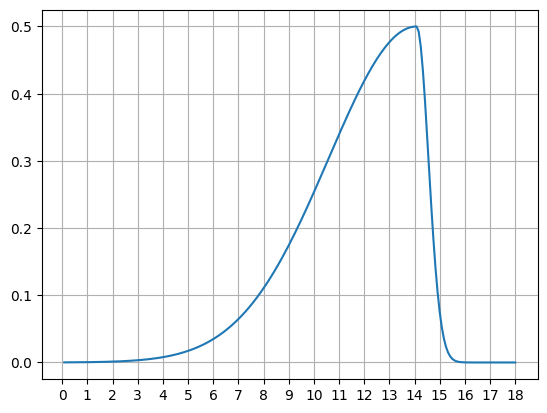

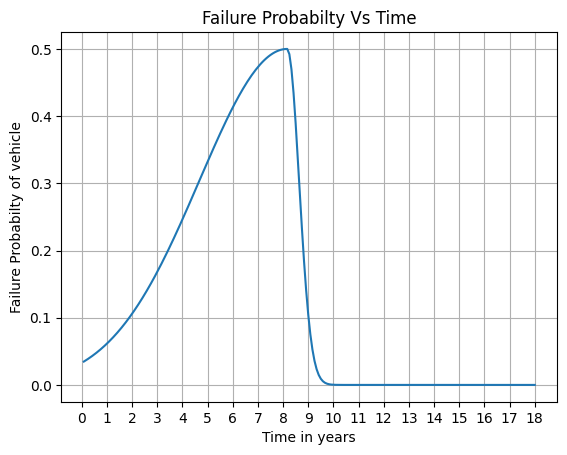

In [19]:
def fail_prob_func(duration,fail_time, fail_prob):
  # fail_time considering  a buffer time after part expiry time.
  past = duration - fail_time
  failure_prob = np.zeros(duration)
  mean = past
  sigma = past/4
  scale = (sigma*np.sqrt(2*np.pi))
  for i in range(0 , past):
    failure_prob[i] = fail_prob*scale*Gaussian(i,mean,sigma)
  for i in range(past , duration):
    failure_prob[i] = stretched_exp_func(i, past,fail_prob, 8 , 2 ) 
  plt.plot(np.linspace(1, duration,duration), failure_prob)
  plt.xticks([i*12 for i in range(years +1)], [i for i in range(years +1)])
  plt.grid()
  plt.show()
  return failure_prob

expected_fail_time = 48
current_time = expected_fail_time
expected_prob_failure = 0.5
failure_prob_with_time = fail_prob_func(duration,expected_fail_time,expected_prob_failure)
# print(failure_prob_time)

def shift_failure_prob(duration, start, arr_failure_prob):
  new_failure_prob = np.zeros(duration)
  for i in range(start-1,-1,-1):
    if i<0 or i>= duration:
      continue
    t = i + duration - start-1
    if t < 0 or t >= duration:
      new_failure_prob[i] = 0
    else :
      new_failure_prob[i] = arr_failure_prob[t]
  return new_failure_prob

plt.plot(np.linspace(1, duration,duration), shift_failure_prob(duration, 144, failure_prob_with_time))
plt.xticks([i*12 for i in range(years +1)], [i for i in range(years +1)])
plt.xlabel('Time in years')
plt.ylabel('Failure Probabilty of vehicle')
plt.title('Failure Probabilty Vs Time')
plt.grid()
plt.show()

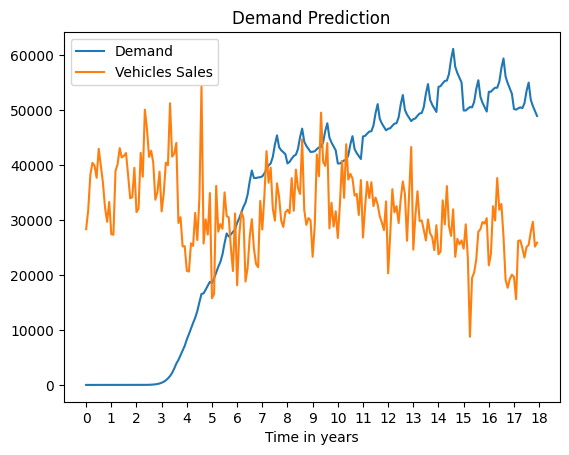

In [26]:
demand = np.zeros(duration)
normalisation_factor = sum(failure_prob_with_time)
for i in range(duration):
  new_vehicles = np.dot(sales, shift_failure_prob(duration, i, failure_prob_with_time))/normalisation_factor
  demand[i] = 1.5*new_vehicles*(1+climate_factor[i%12]**3)*(1+(economic_factor[i//12])**3)*(1+(brand_factor[i//12])**3)

plt.plot(time, demand)
plt.plot(time, sales)
plt.xticks([i*12 for i in range(years +1)], [i for i in range(years +1)])
plt.xlabel('Time in years')
plt.legend([ 'Demand','Vehicles Sales'])
plt.title('Demand Prediction')
plt.show()
# random_values = np.random.uniform(low=-1, high=1, size=(10,))
# print(random_values)

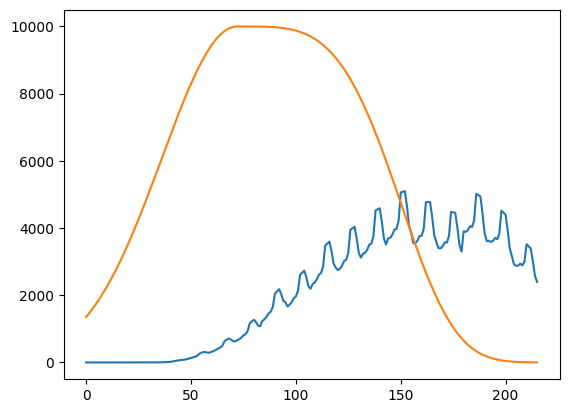

In [ ]:
new_demand = np.zeros(duration)
normalisation_factor = sum(failure_prob_with_time)
scale_factor = 0.4

for i in range(duration):
  new_vehicles = np.dot(vehicles, shift_failure_prob(duration, i, failure_prob_with_time))/normalisation_factor
  new_demand[i] = scale_factor*new_vehicles*(1+climate_factor[i%12]**3)*(1+(economic_factor[i//12])**3)*(1+(brand_factor[i//12])**3)

plt.plot(time, new_demand)
plt.plot(time, vehicles)
plt.show()
# random_values = np.random.uniform(low=-1, high=1, size=(10,))
# print(random_values)

<ipython-input-16-3a923c45e25f>:6: RuntimeWarning: invalid value encountered in double_scalars
  prediction[i] = np.sum(data[start:end])/(end-start)


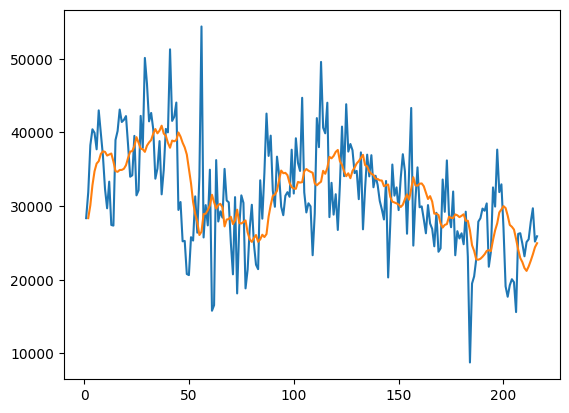

In [ ]:
def moving_average(data, t):
  prediction = np.zeros(len(data))
  for i in range(len(prediction)):
    start = max(i-t, 0)
    end = i
    prediction[i] = np.sum(data[start:end])/(end-start)
  time = np.linspace(1,len(sales),len(sales))
  plt.plot(time, sales)
  plt.plot(time, prediction)
  plt.show()

moving_average(sales, 10)

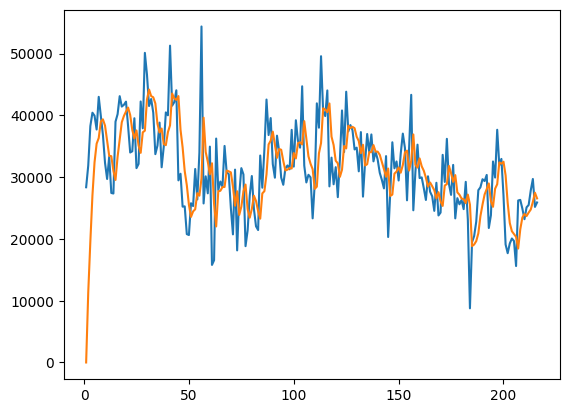

In [ ]:
def exponential_smoothing(data, a):
  prediction = np.zeros(len(data))
  for i in range(1, len(prediction)):
    prediction[i] = (1-a)*prediction[i-1] + a*sales[i-1]
  time = np.linspace(1,len(sales),len(sales))
  plt.plot(time, sales)
  plt.plot(time, prediction)
  plt.show()

exponential_smoothing(sales, 0.4)

In [ ]:
def croston(data, a, b):
  prediction = np.zeros(len(data))
  s = np.zeros(len(data))
  k = np.zeros(len(data))
  for i in range(1, len(prediction)):
    s[i] = (1-a)*s[i-1] + a*sales[i-1]
    k[i] = (1-b)*k[i-1] + b*k[i-1]
  time = np.linspace(1,len(sales),len(sales))
  plt.plot(time, sales)
  plt.plot(time, prediction)
  plt.show()

exponential_smoothing(sales, 0.4)